# Evaluation of the anomaly detection

This notebook evaluates trained autoencoders

---

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm.notebook import tqdm

from data_loading import TimeSeriesWithAnoms
from params import TcnAeParams, tcn_ae_params, baseline_params
from evaluation import EvaluationMetric, PrecisionAtK, F1Score, evaluate_model
from train_models import prepare_data
from detectors import SubsequenceAnomalyDetector, TcnAeDetector, RandomDetector, LofDetector

In [2]:
torch.manual_seed(tcn_ae_params.random_seed)

### Load and prepare data

We will load all time series and normalize them (we use the same function as in the training script)

In [3]:
all_series = prepare_data()
all_series[0]

TimeSeriesWithAnoms(name='SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_0', values=array([0.78267852, 0.77670079, 0.77072901, ..., 0.54603821, 0.54006643,
       0.5340887 ]), annotations=[(1070, 1270), (3245, 3445), (5200, 5400), (6245, 6445), (7468, 7668), (10367, 10567), (11337, 11537), (13161, 13361), (13686, 13886), (14208, 14408), (16211, 16411), (19490, 19690), (23336, 23536), (24398, 24598), (28747, 28947), (30869, 31069), (31927, 32127), (33280, 33480), (35285, 35485), (38473, 38673), (43829, 44029), (45524, 45724), (48857, 49057), (49095, 49295), (50200, 50400), (51410, 51610), (52926, 53126), (56144, 56344), (60167, 60367), (62178, 62378), (63715, 63915), (63976, 64176), (66221, 66421), (69191, 69391), (69961, 70161), (72081, 72281), (72694, 72894), (73269, 73469), (75091, 75291), (76875, 77075), (77531, 77731), (84824, 85024), (85373, 85573), (87237, 87437), (89419, 89619), (90802, 91002), (94382, 94582), (95438, 95638), (95713, 95913), (96599, 96799), (97139, 97

In [4]:
# number of time series
len(all_series)

14

### Run anomaly detection with baseline models

First, we will examine anomaly detection quality with two baseline models:

- _RandomDetector_ - returns random subsequences
- _LofDetector_ - based on the well-known [Local Outlier Factor](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html)
anomaly detection algorithm for multidimensional data

We will detect anomalies with both baseline models and calculate metrics for each time series.

In [5]:
def evaluate_baseline(
    baseline_detector: SubsequenceAnomalyDetector,
    all_series: list[TimeSeriesWithAnoms],
    metrics: list[EvaluationMetric],
) -> dict[str, dict[str, float]]:
    """Evaluate a baseline subsequence anomaly detection
    model for each time series

    Returns dict:
    {series_name -> {metric_name -> metric_value}}
    """
    return {
        series.name: evaluate_model(
            series, baseline_detector, metrics
        )
        for series in tqdm(all_series)
    }

In [6]:
metrics = [PrecisionAtK(), F1Score()]

In [7]:
random_detector = RandomDetector(random_seed=baseline_params.random_seed)
random_metrics = evaluate_baseline(
    random_detector, all_series, metrics
)

  0%|          | 0/14 [00:00<?, ?it/s]

In [8]:
lof_detector = LofDetector(
    n_neighbors=baseline_params.lof_n_neighbors,
    other_lof_params=baseline_params.lof_other_params,
)
lof_metrics = evaluate_baseline(
    lof_detector, all_series, metrics
)

  0%|          | 0/14 [00:00<?, ?it/s]

### Run anomaly detection with TCN autoencoders

We will perform the following operations, for each time series:

- load trained model on the series
- get pointwise reconstruction errors on the series
- extract sliding windows from the errors and detect anomalous windows
- calculate metrics

In [9]:
def evaluate_tcnae(
    all_series: list[TimeSeriesWithAnoms],
    metrics: list[EvaluationMetric],
    params: TcnAeParams,
) -> dict[str, dict[str, float]]:
    """Loads the TCN autoencoder model and evaluates detection for each series

    Returns dict:
    {series_name -> {metric_name -> metric_value}}
    """
    series_metrics_dict: dict[str, dict[str, float]] = {}
    for series in tqdm(all_series):
        detector = TcnAeDetector.load(series, params)
        series_metrics_dict[series.name] = evaluate_model(
            series, detector, metrics
        )
    return series_metrics_dict

In [10]:
tcnae_metrics = evaluate_tcnae(
    all_series=all_series,
    metrics=metrics,
    params=tcn_ae_params,
)

  0%|          | 0/14 [00:00<?, ?it/s]

In [11]:
tcnae_metrics

{'SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_0': {'precision@k': 1.0,
  'f1-score': np.float64(0.78325)},
 'SinusRW_Length_106000_AnomalyL_100_AnomalyN_60_NoisePerc_0': {'precision@k': 0.9833333333333333,
  'f1-score': np.float64(0.5258333333333334)},
 'SinusRW_Length_104000_AnomalyL_200_AnomalyN_20_NoisePerc_0': {'precision@k': 0.9,
  'f1-score': np.float64(0.64975)},
 'SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_5': {'precision@k': 1.0,
  'f1-score': np.float64(0.42333333333333334)},
 'SinusRW_Length_148000_AnomalyL_800_AnomalyN_60_NoisePerc_0': {'precision@k': 1.0,
  'f1-score': np.float64(0.5366041666666667)},
 'SinusRW_Length_124000_AnomalyL_400_AnomalyN_60_NoisePerc_0': {'precision@k': 1.0,
  'f1-score': np.float64(0.7089166666666666)},
 'SinusRW_Length_116000_AnomalyL_200_AnomalyN_80_NoisePerc_0': {'precision@k': 1.0,
  'f1-score': np.float64(0.7475)},
 'SinusRW_Length_108000_AnomalyL_200_AnomalyN_40_NoisePerc_0': {'precision@k': 0.875,
  'f1-score': n

### Present results

We'll present evaluation metrics for each time series. Then, we will show summaries.

In [12]:
precision_at_k_results = pd.DataFrame({
    detector_name: pd.Series({k: v['precision@k'] for k,v in detector_metrics.items()})
    for detector_name, detector_metrics in [
        ("Random", random_metrics),
        ("LOF", lof_metrics),
        ("TCN AE", tcnae_metrics)
    ]
})
precision_at_k_results

,Random,LOF,TCN AE
SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_0,0.200000,1.000000,1.000000
SinusRW_Length_106000_AnomalyL_100_AnomalyN_60_NoisePerc_0,0.116667,1.000000,0.983333
SinusRW_Length_104000_AnomalyL_200_AnomalyN_20_NoisePerc_0,0.100000,1.000000,0.900000
SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_5,0.183333,1.000000,1.000000
SinusRW_Length_148000_AnomalyL_800_AnomalyN_60_NoisePerc_0,0.600000,1.000000,1.000000
SinusRW_Length_124000_AnomalyL_400_AnomalyN_60_NoisePerc_0,0.433333,1.000000,1.000000
SinusRW_Length_116000_AnomalyL_200_AnomalyN_80_NoisePerc_0,0.275000,1.000000,1.000000
SinusRW_Length_108000_AnomalyL_200_AnomalyN_40_NoisePerc_0,0.150000,1.000000,0.875000
SinusRW_Length_120000_AnomalyL_200_AnomalyN_100_NoisePerc_0,0.290000,1.000000,1.000000
SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_20,0.200000,1.000000,1.000000


In [13]:
f1_score_results = pd.DataFrame({
    detector_name: pd.Series({k: v['f1-score'] for k,v in detector_metrics.items()})
    for detector_name, detector_metrics in [
        ("Random", random_metrics),
        ("LOF", lof_metrics),
        ("TCN AE", tcnae_metrics)
    ]
})
f1_score_results

,Random,LOF,TCN AE
SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_0,0.137083,0.244583,0.783250
SinusRW_Length_106000_AnomalyL_100_AnomalyN_60_NoisePerc_0,0.049333,0.342333,0.525833
SinusRW_Length_104000_AnomalyL_200_AnomalyN_20_NoisePerc_0,0.020250,0.310000,0.649750
SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_5,0.105750,0.265083,0.423333
SinusRW_Length_148000_AnomalyL_800_AnomalyN_60_NoisePerc_0,0.383396,0.157604,0.536604
SinusRW_Length_124000_AnomalyL_400_AnomalyN_60_NoisePerc_0,0.190292,0.181417,0.708917
SinusRW_Length_116000_AnomalyL_200_AnomalyN_80_NoisePerc_0,0.153625,0.158938,0.747500
SinusRW_Length_108000_AnomalyL_200_AnomalyN_40_NoisePerc_0,0.072250,0.268750,0.587875
SinusRW_Length_120000_AnomalyL_200_AnomalyN_100_NoisePerc_0,0.185500,0.207900,0.711050
SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_20,0.097167,0.227500,0.392250


In [14]:
precision_at_k_results.mean()

Random    0.285595
LOF       0.997619
TCN AE    0.981548
dtype: float64

In [15]:
f1_score_results.mean()

Random    0.156837
LOF       0.238023
TCN AE    0.543618
dtype: float64

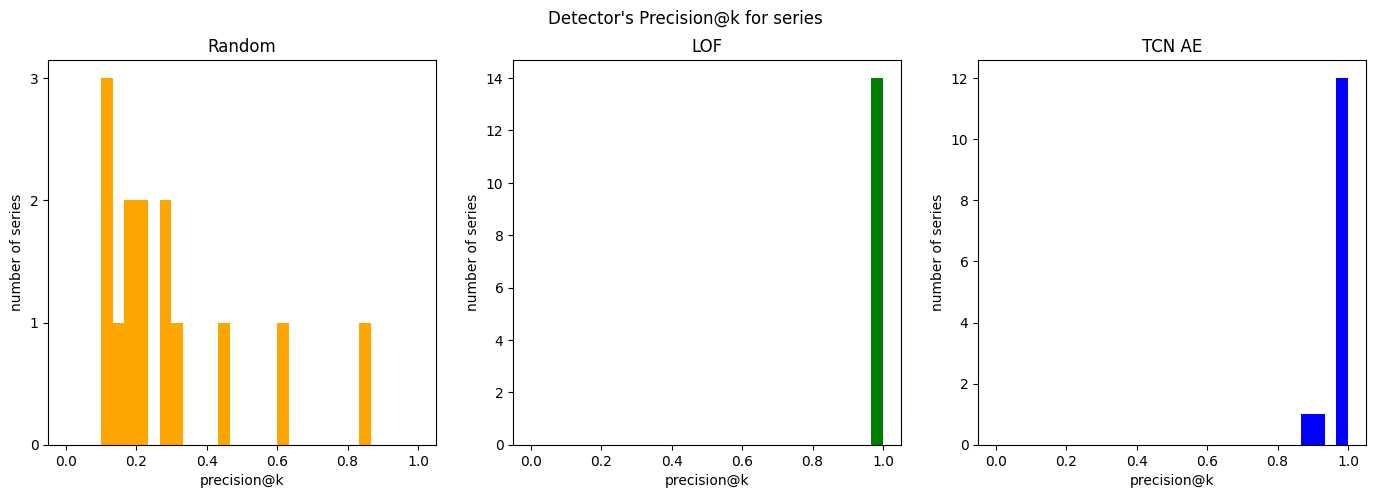

In [16]:
bins = 30

fig, axes = plt.subplots(1, 3, figsize=(17, 5))
fig.suptitle("Detector's Precision@k for series")

for detector_label, color, ax in zip(
    ["Random", "LOF", "TCN AE"],
    ["orange", "green", "blue"],
    axes
):
    ax.set_title(detector_label)
    ax.hist(
        precision_at_k_results[detector_label],
        bins=bins,
        color=color,
        range=(0,1)
    )
    ax.set_xlabel("precision@k")
    ax.set_ylabel("number of series")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.savefig("img/precision_at_k.png")

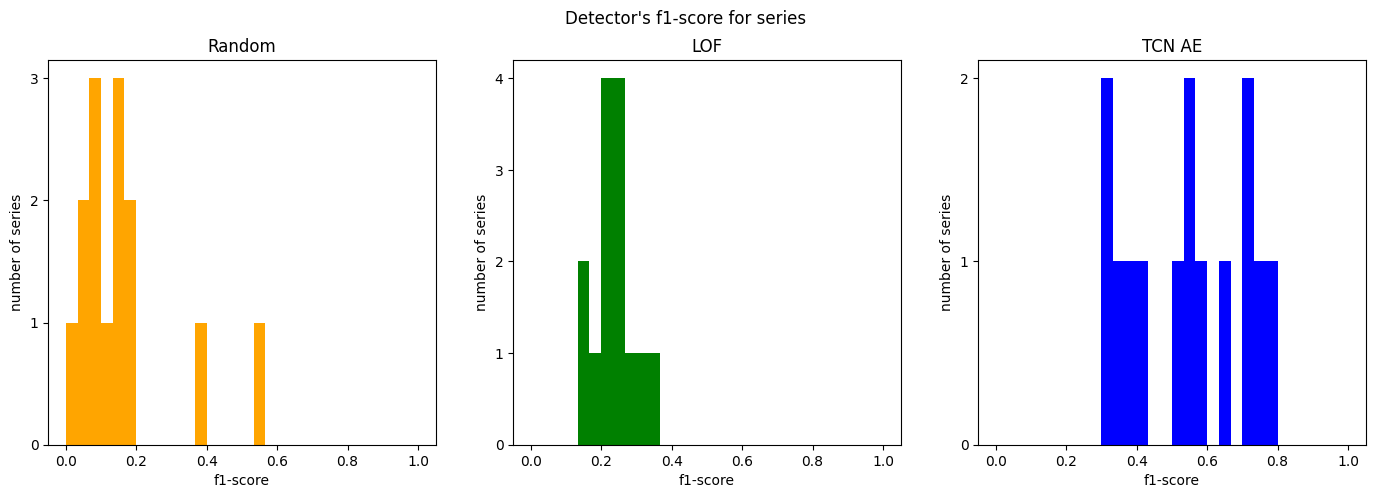

In [17]:
bins = 30

fig, axes = plt.subplots(1, 3, figsize=(17, 5))
fig.suptitle("Detector's f1-score for series")

for detector_label, color, ax in zip(
    ["Random", "LOF", "TCN AE"],
    ["orange", "green", "blue"],
    axes
):
    ax.set_title(detector_label)
    ax.hist(
        f1_score_results[detector_label],
        bins=bins,
        color=color,
        range=(0,1)
    )
    ax.set_xlabel("f1-score")
    ax.set_ylabel("number of series")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.savefig("img/f1_score.png")